# Response functions
In this notebook an overview is provided of the response function that are available in Pastas. The below table summarizes all the response functions that are tested and supported. Others may be available but are not yet fully supported.

|Name | Parameters | Impulse response function | Description|
|:--- | --- | ---  | --- |
| FourParam |4 - A, n, a, b| $$ h(t) = At^{n-1} \exp (-t/a -ab/t) $$ | Response function with four parameters that may be used for many purposes. Many other response function are a simplification of this function. |
| Gamma |3 - A, a, n | $$ h(t) = At^{n-1} \exp (-t/a) $$ | Three parameter versino of FourParam, used for all sorts of stresses ($b=0$) |
| Exponential |2 - A, a | $$ h(t) = A \exp (-t/a) $$ | Response function that can be used for stresses that have an (almost) instant effect. ($n=1$ and $b=0$)|
| Hantush |3 - A, a, b |$$ h(t) = At^{-1} \exp (-t/a - ab/t) $$ | Response function commonly used for groundwater abstraction wells ($n=0$) |
| Polder |3 - a, b, c | $$ h(t) = At^{-3/2} \exp (-t/a -b/t) $$ | Response function commonly used to simulate the effects of (river) water levels on the groundwater levels ($n=-1/2$) |
| DoubleExponential |4 - A, $\alpha$, a1,a2| $$ h(t) = A ((1 - \alpha) \exp (-t/a_1) +\alpha \exp (-t/a_2)) $$ | Response Function with a double exponential, simulating a fast and slow response. |
| Edelman | 1 - $\beta$ | | The function of Edelman, describing the propagation of an instantaneous water level change into an adjacent half-infinite aquifer. | 
| HantushWellModel | 3 - A, a, b| | A special implementation of the Hantush well function for multiple wells. |

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import pastas as ps

ps.show_versions()

Python version: 3.7.6 | packaged by conda-forge | (default, Jun  1 2020, 18:33:30) 
[Clang 9.0.1 ]
Numpy version: 1.18.5
Scipy version: 1.4.0
Pandas version: 1.0.5
Pastas version: 0.15.0b


## Parameters
**up** - This parameters determines whether the influence of the stress goes up or down, hence a positive or a negative response function.

**meanstress** - This parameter is used to estimate the initial value of the stationary effect of a stress. Hence the effect when a stress stays at an unit level for infinite amount of time.

**cutoff** - This parameter determines for how many time steps the response 
is calculated. This reduces calculation times as it reduces the length of the array the stress is convolved with. The default value is 0.99, meaning that the response is cutoff after 99% of the effect of the stress impulse has occurred. A minimum of length of three times the simulation time step is applied.




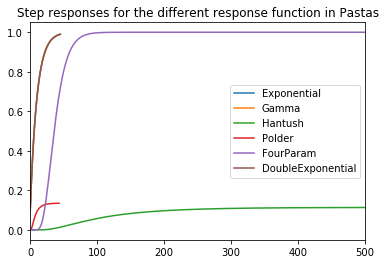

,initial,pmin,pmax,vary,name
Exponential_A,1,1e-05,100,True,Exponential
Exponential_a,10,0.01,1000,True,Exponential
Gamma_A,1,1e-05,100,True,Gamma
Gamma_n,1,0.1,10,True,Gamma
Gamma_a,10,0.01,1000,True,Gamma
Hantush_A,1,0,100,True,Hantush
Hantush_a,100,0.001,10000,True,Hantush
Hantush_b,1,1e-06,25,True,Hantush
Polder_A,1,0,2,True,Polder
Polder_a,10,0.01,1000,True,Polder


In [3]:
# Exponential function
responses = {}
cutoff = 0.99 # 
meanstress = 1
up = True

Exp = ps.Exponential(up=up, meanstress=meanstress, cutoff=cutoff)
responses["Exponential"] = Exp

Gamma = ps.Gamma(up=up, meanstress=meanstress, cutoff=cutoff)
responses["Gamma"] = Gamma

Hantush = ps.Hantush(up=up, meanstress=meanstress, cutoff=cutoff)
responses["Hantush"] = Hantush

Polder = ps.Polder(up=up, meanstress=meanstress, cutoff=cutoff)
responses["Polder"] = Polder

FourParam = ps.FourParam(up=up, meanstress=meanstress, cutoff=cutoff)
responses["FourParam"] = FourParam

DoubleExp = ps.DoubleExponential(up=up, meanstress=meanstress, cutoff=cutoff)
responses["DoubleExponential"] = DoubleExp

parameters = pd.DataFrame()

for name, response in responses.items():
    p = response.get_init_parameters(name)
    parameters = parameters.append(p)
    plt.plot(response.step(p.initial), label=name)
plt.title("Step responses for the different response function in Pastas")
plt.legend()
plt.xlim(0,500)
plt.show()


## Parameter settings
 


In [ ]:
parameters


